<a href="https://colab.research.google.com/github/oj3v0ns/MMM/blob/main/Mass_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_upper_funnel_causal_approach.html

##Setup

In [ ]:
#import packages

import warnings

!pip install pymc-marketing pymc-extras

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from pymc_extras.prior import Prior
import ipywidgets as widgets
from IPython.display import display, clear_output

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100


In [ ]:
#load data from github

excel_url = "https://github.com/oj3v0ns/MMM/raw/05bc288de80881239512de2fc9a9202d761e2dc9/Project%20Input%20Data.xlsx"
df = pd.read_excel(excel_url, sheet_name=0)

# trend feature
n = df.shape[0]
df["t"] = range(n)

df.head()


,Date,Accounts Subscriptions,Google_Display_Impressions,Meta_Impressions,Google_Generic_Paid_Search_Impressions,TV_GRP,Influencers_Views,Google_Brand_Paid_Search_Clicks,YouTube_Impressions,Dates_School_Holidays,Competitors Promotion,Promotion,t
0,2022-01-01,4182.0,49.0,3501804.0,152181.0,0.000000,0.0,4049,1951.0,0,14.0,14.0,0
1,2022-01-08,5167.5,1061.0,2896152.0,167010.0,0.000000,698.0,4497,1914.0,6,14.0,14.0,1
2,2022-01-15,6229.0,20.0,2214403.0,179189.0,274.285714,353.0,5787,4801.0,7,14.0,14.0,2
3,2022-01-22,7801.5,3088.0,2567241.0,209859.0,1920.000000,58.0,7032,5925.0,7,14.0,14.0,3
4,2022-01-29,9505.0,11.0,3721507.0,214967.0,1920.000000,88.0,6943,13061.0,7,14.0,14.0,4


##Model specification

In [ ]:
#define x and y

X = df.drop("Accounts Subscriptions", axis=1)
y = df["Accounts Subscriptions"]

In [ ]:
#customise the default priors

my_model_config = {
    'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1),
 'saturation_beta': Prior("HalfNormal", sigma=2)
 }

In [ ]:
#specify the model

my_sampler_config = {"progressbar": True}

mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    target_column="Accounts Subscriptions",
    channel_columns=["Google_Display_Impressions", "Meta_Impressions", "Google_Generic_Paid_Search_Impressions", "TV_GRP", "Influencers_Views", "Google_Brand_Paid_Search_Clicks", "YouTube_Impressions"],
    control_columns=["Dates_School_Holidays", "Competitors Promotion", "Promotion", "t"],
    yearly_seasonality=2,
    time_varying_intercept=False, #change to true if poss
    time_varying_media=False, #change to true if poss
)



In [ ]:
#build the model and add contribution variables in original scale
mmm.build_model(X, y)
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)

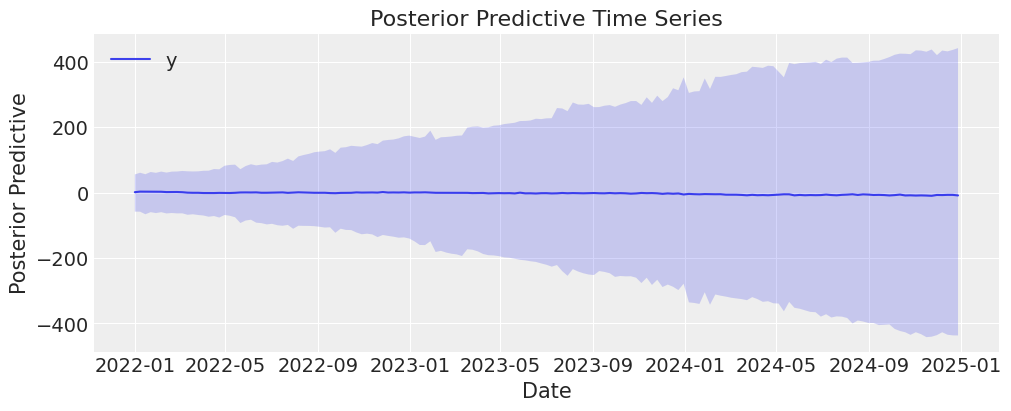

In [ ]:
#assess influence of priors using prior predictive samples

mmm.sample_prior_predictive(X, y, samples=2_000)
fig, axes = mmm.plot.prior_predictive()

##Fit the model

In [ ]:
mmm.fit(
    X=X,
    y=y,
    chains=4, # You can reduce this (e.g., to 2) for faster execution, but it affects convergence diagnostics.
    tune=2_000, # Increased tune steps to help resolve 'Not enough samples to build a trace' error.
    draws=2_000, # Increased number of draws for potentially better sampling. Reduce for speed if desired after successful run.
    target_accept=0.9, # Keeping this high (closer to 1) for better sampling, but can be slightly lowered for speed (e.g., 0.8) at risk of worse sampling.
)

Output()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [ ]:
mmm.save(fname="mmm_model")

In [ ]:
loaded_mmm = MMM.load(fname="mmm_model")
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the categories of variables for filtering
channel_cols = [
    "Google_Display_Impressions",
    "Meta_Impressions",
    "Google_Generic_Paid_Search_Impressions",
    "TV_GRP",
    "Influencers_Views",
    "Google_Brand_Paid_Search_Clicks",
    "YouTube_Impressions",
]
control_cols = [
    "Dates_School_Holidays",
    "Competitors Promotion",
    "Promotion",
    "t",
]
other_cols = ["yearly_seasonality_contribution", "intercept_contribution"]

all_available_cols = channel_cols + control_cols + other_cols

# Create interactive widgets
channel_selector = widgets.SelectMultiple(
    options=channel_cols,
    value=channel_cols[:2],  # Select first two channels by default
    description='Channels',
    disabled=False,
    rows=len(channel_cols),
    layout=widgets.Layout(width='auto', height='auto')
)

control_selector = widgets.SelectMultiple(
    options=control_cols,
    value=control_cols[:2], # Select first two controls by default
    description='Controls',
    disabled=False,
    rows=len(control_cols),
    layout=widgets.Layout(width='auto', height='auto')
)

other_selector = widgets.SelectMultiple(
    options=other_cols,
    value=other_cols, # Select all other contributions by default
    description='Others',
    disabled=False,
    rows=len(other_cols),
    layout=widgets.Layout(width='auto', height='auto')
)

# Output widget to display the plot
plot_output = widgets.Output()

def plot_contributions(selected_channels, selected_controls, selected_others):
    with plot_output:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(15, 8))

        selected_columns = list(selected_channels) + list(selected_controls) + list(selected_others)

        if not selected_columns:
            print("Please select at least one variable to display.")
            return

        plot_df_filtered = combined_contributions_df_individual[['date'] + selected_columns].set_index('date')

        if not plot_df_filtered.empty:
            plot_df_filtered.plot(ax=ax, kind='line', marker='o', markersize=2, linewidth=1.5)

            ax.set_title('Individual Component Contributions Over Time (Filtered)');
            ax.set_ylabel('Contribution');
            ax.set_xlabel('Date');
            ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print("No data to plot for the selected variables.")

# Link widgets to the plotting function
interactive_plot = widgets.interactive(plot_contributions,
                                       selected_channels=channel_selector,
                                       selected_controls=control_selector,
                                       selected_others=other_selector)

# Display the widgets and the plot output
display(widgets.VBox([widgets.HBox([channel_selector, control_selector, other_selector]), plot_output]))
interactive_plot

interactive(children=(SelectMultiple(description='Channels', index=(0, 1), layout=Layout(height='auto', width=…

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the categories of variables for filtering
channel_cols = [
    "Google_Display_Impressions",
    "Meta_Impressions",
    "Google_Generic_Paid_Search_Impressions",
    "TV_GRP",
    "Influencers_Views",
    "Google_Brand_Paid_Search_Clicks",
    "YouTube_Impressions",
]
control_cols = [
    "Dates_School_Holidays",
    "Competitors Promotion",
    "Promotion",
    "t",
]
other_cols = ["yearly_seasonality_contribution", "intercept_contribution"]

all_available_cols = channel_cols + control_cols + other_cols

# Create interactive widgets
channel_selector = widgets.SelectMultiple(
    options=channel_cols,
    value=channel_cols[:2],  # Select first two channels by default
    description='Channels',
    disabled=False,
    rows=len(channel_cols),
    layout=widgets.Layout(width='auto', height='auto')
)

control_selector = widgets.SelectMultiple(
    options=control_cols,
    value=control_cols[:2], # Select first two controls by default
    description='Controls',
    disabled=False,
    rows=len(control_cols),
    layout=widgets.Layout(width='auto', height='auto')
)

other_selector = widgets.SelectMultiple(
    options=other_cols,
    value=other_cols, # Select all other contributions by default
    description='Others',
    disabled=False,
    rows=len(other_cols),
    layout=widgets.Layout(width='auto', height='auto')
)

# Output widget to display the plot
plot_output = widgets.Output()

def plot_contributions(selected_channels, selected_controls, selected_others):
    with plot_output:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(15, 8))

        selected_columns = list(selected_channels) + list(selected_controls) + list(selected_others)

        if not selected_columns:
            print("Please select at least one variable to display.")
            return

        plot_df_filtered = combined_contributions_df_individual[['date'] + selected_columns].set_index('date')

        if not plot_df_filtered.empty:
            plot_df_filtered.plot(ax=ax, kind='line', marker='o', markersize=2, linewidth=1.5)

            ax.set_title('Individual Component Contributions Over Time (Filtered)');
            ax.set_ylabel('Contribution');
            ax.set_xlabel('Date');
            ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print("No data to plot for the selected variables.")

# Link widgets to the plotting function
interactive_plot = widgets.interactive(plot_contributions,
                                       selected_channels=channel_selector,
                                       selected_controls=control_selector,
                                       selected_others=other_selector)

# Display the widgets and the plot output
display(widgets.VBox([widgets.HBox([channel_selector, control_selector, other_selector]), plot_output]))
interactive_plot

interactive(children=(SelectMultiple(description='Channels', index=(0, 1), layout=Layout(height='auto', width=…

In [ ]:
mmm.table()

                                 Variable  Expression                                  Dimensions                  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                          channel_scale =  Data                                        channel[7]                  
                           target_scale =  Data                                                                    
                           channel_data =  Data                                        date[157] × channel[7]      
                            target_data =  Data                                        date[157]                   
                           control_data =  Data                                        date[157] × control[4]      
                              dayofyear =  Data                                        date[157]                   
                                                                                                                   
                 intercept_contribution ~  Normal(0, 2)                                                            
                          adstock_alpha ~  Beta(1, 3)                                                              
                         saturation_lam ~  Gamma(3, f())                                                           
                        saturation_beta ~  HalfNormal(0, 2)                                                        
                          gamma_control ~  Normal(0, 2)                                control[4]                  
                          gamma_fourier ~  Laplace(0, 1)                               fourier_mode[4]             
                                y_sigma ~  HalfNormal(0, 2)                                                        
                                                                                       Parameter count = 13        
                                                                                                                   
                   channel_contribution =  f(saturation_beta, saturation_lam,          date[157] × channel[7]      
                                           adstock_alpha)                                                          
  total_media_contribution_original_scale  f(saturation_beta, saturation_lam,                                      
                                        =  adstock_alpha)                                                          
                   control_contribution =  f(gamma_control)                            date[157] × control[4]      
                   fourier_contribution =  f(gamma_fourier)                            date[157] × fourier_mode[4] 
        yearly_seasonality_contribution =  f(gamma_fourier)                            date[157]                   
    channel_contribution_original_scale =  f(saturation_beta, saturation_lam,          date[157] × channel[7]      
                                           adstock_alpha)                                                          
    control_contribution_original_scale =  f(gamma_control)                            date[157] × control[4]      
  intercept_contribution_original_scale =  f(intercept_contribution)                                               
 yearly_seasonality_contribution_origina…  f(gamma_fourier)                            date[157]                   
                                        =                                                                          
                       y_original_scale =  f(y)                                        date[157]                   
                                                                                                                   
                                      y ~  Normal(f(intercept_contribution,            date[157]                   
                                           gamma_fourier

##Model diagnostics

In [ ]:
#number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

In [ ]:
#fit result
mmm.fit_result

<xarray.Dataset> Size: 292MB
Dimensions:                                         (chain: 4, draw: 2000,
                                                     control: 4,
                                                     fourier_mode: 4,
                                                     date: 157, channel: 7)
Coordinates:
  * chain                                           (chain) int64 32B 0 1 2 3
  * draw                                            (draw) int64 16kB 0 ... 1999
  * control                                         (control) <U21 336B 'Comp...
  * fourier_mode                                    (fourier_mode) <U5 80B 's...
  * date                                            (date) datetime64[ns] 1kB ...
  * channel                                         (channel) <U38 1kB 'Googl...
Data variables: (12/17)
    adstock_alpha                                   (chain, draw) float64 64kB ...
    gamma_control                                   (chain, draw, control) float64 256kB ...
    gamma_fourier                                   (chain, draw, fourier_mode) float64 256kB ...
    intercept_contribution                          (chain, draw) float64 64kB ...
    saturation_beta                                 (chain, draw) float64 64kB ...
    saturation_lam                                  (chain, draw) float64 64kB ...
    ...                                              ...
    fourier_contribution                            (chain, draw, date, fourier_mode) float64 40MB ...
    intercept_contribution_original_scale           (chain, draw) float64 64kB ...
    total_media_contribution_original_scale         (chain, draw) float64 64kB ...
    y_original_scale                                (chain, draw, date) float64 10MB ...
    yearly_seasonality_contribution                 (chain, draw, date) float64 10MB ...
    yearly_seasonality_contribution_original_scale  (chain, draw, date) float64 10MB ...
Attributes:
    created_at:                 2026-02-26T10:10:33.429872+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.27.1
    sampling_time:              1481.4973578453064
    tuning_steps:               2000
    pymc_marketing_version:     0.18.2

In [ ]:
#model summary
az.summary(
    data=mmm.fit_result,
    var_names=[
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam",
        "y_sigma",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
adstock_alpha,0.348,0.089,0.174,0.508,0.001,0.001,6031.0,3757.0,1.0
gamma_control[Competitors Promotion],-0.005,0.001,-0.007,-0.002,0.000,0.000,5492.0,5897.0,1.0
gamma_control[Dates_School_Holidays],0.011,0.002,0.007,0.016,0.000,0.000,6780.0,5822.0,1.0
gamma_control[Promotion],0.004,0.001,0.002,0.006,0.000,0.000,7810.0,5876.0,1.0
gamma_control[t],-0.000,0.000,-0.001,0.000,0.000,0.000,5185.0,5467.0,1.0
gamma_fourier[sin_1],0.029,0.009,0.012,0.044,0.000,0.000,6593.0,5212.0,1.0
gamma_fourier[sin_2],0.037,0.010,0.018,0.056,0.000,0.000,5328.0,5632.0,1.0
gamma_fourier[cos_1],0.024,0.008,0.008,0.040,0.000,0.000,9327.0,5448.0,1.0
gamma_fourier[cos_2],-0.017,0.008,-0.032,-0.002,0.000,0.000,8699.0,5354.0,1.0
intercept_contribution,0.358,0.025,0.308,0.403,0.000,0.000,5502.0,5383.0,1.0


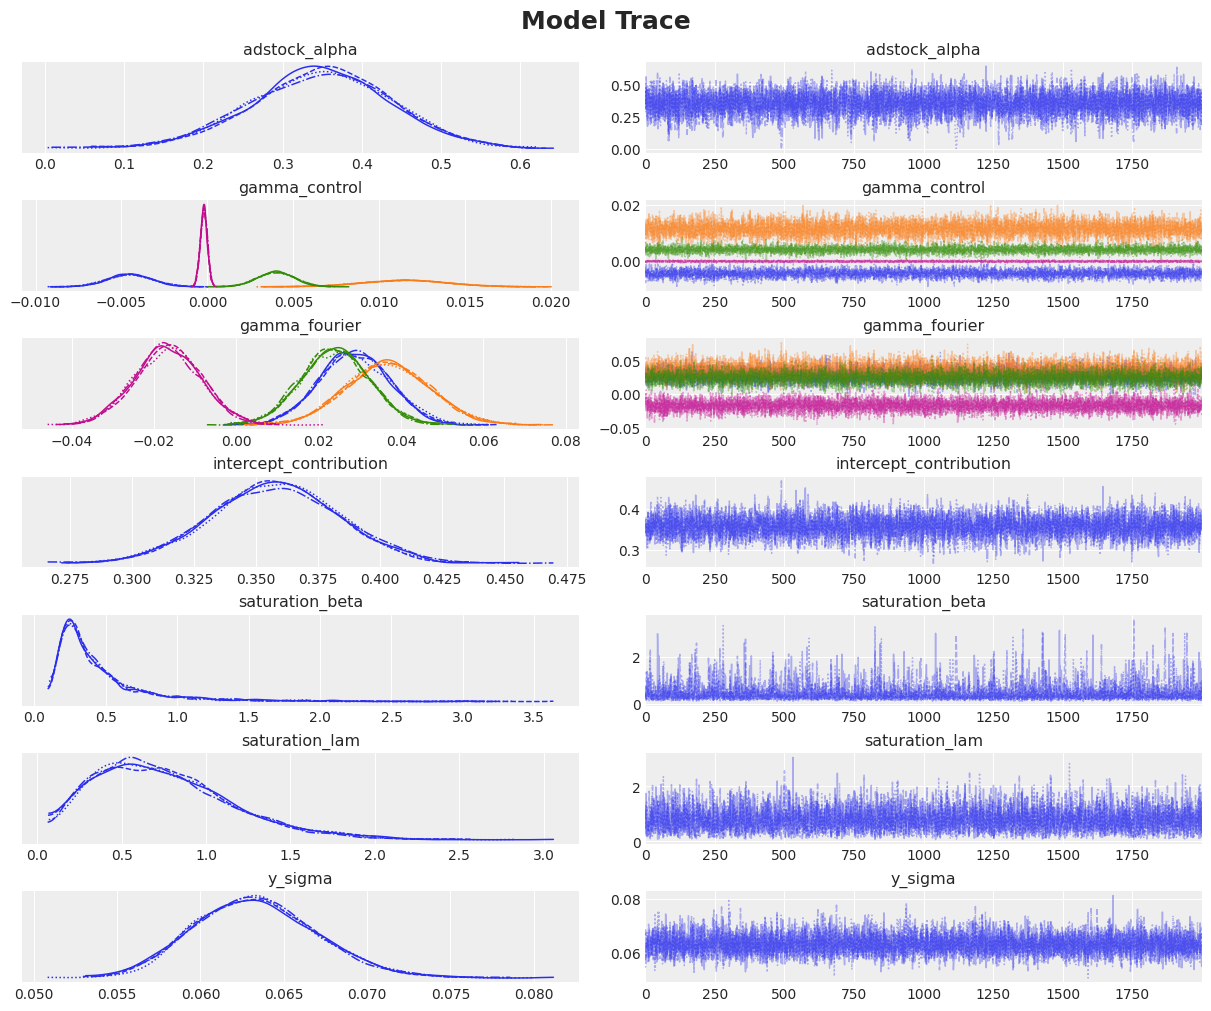

In [ ]:
#plot the trace

_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam",
        "y_sigma",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

In [ ]:
#sample from posterior predictive

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

mmm.sample_posterior_predictive(X=X, random_seed=rng)

Output()

<xarray.Dataset> Size: 20MB
Dimensions:           (date: 157, sample: 8000)
Coordinates:
  * date              (date) datetime64[ns] 1kB 2022-01-01 ... 2024-12-28
  * sample            (sample) object 64kB MultiIndex
  * chain             (sample) int64 64kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 64kB 0 1 2 3 4 ... 1995 1996 1997 1998 1999
Data variables:
    y                 (date, sample) float64 10MB 0.4265 0.3663 ... 0.4375
    y_original_scale  (date, sample) float64 10MB 4.335e+03 ... 4.446e+03
Attributes:
    created_at:                 2026-02-26T10:18:38.921569+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.27.1

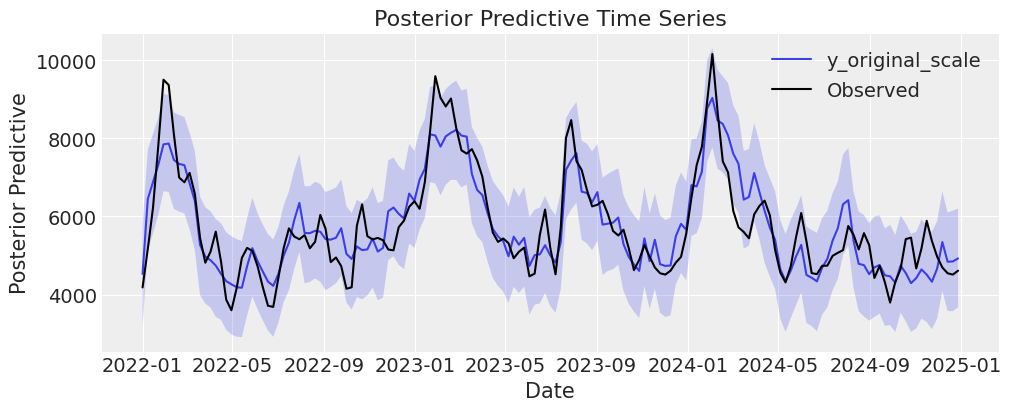

In [ ]:
#check predicted vs actual performance

fig, axes = mmm.plot.posterior_predictive(var=["y_original_scale"], hdi_prob=0.94)
sns.lineplot(
    data=df, x="Date", y="Accounts Subscriptions", color="black", label="Observed", ax=axes[0][0]
);

In [ ]:
#calculate basic model stats

def calculate_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


y_true = mmm.y.values
y_pred_mean = mmm.posterior_predictive["y_original_scale"].mean(dim=["chain", "draw"])

r2_score = calculate_r2(y_true, y_pred_mean)
mape_score = calculate_mape(y_true, y_pred_mean)

print(f"R-squared (R2): {r2_score:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_score:.2f}%")

R-squared (R2): 0.7864
Mean Absolute Percentage Error (MAPE): 8.50%


##Results

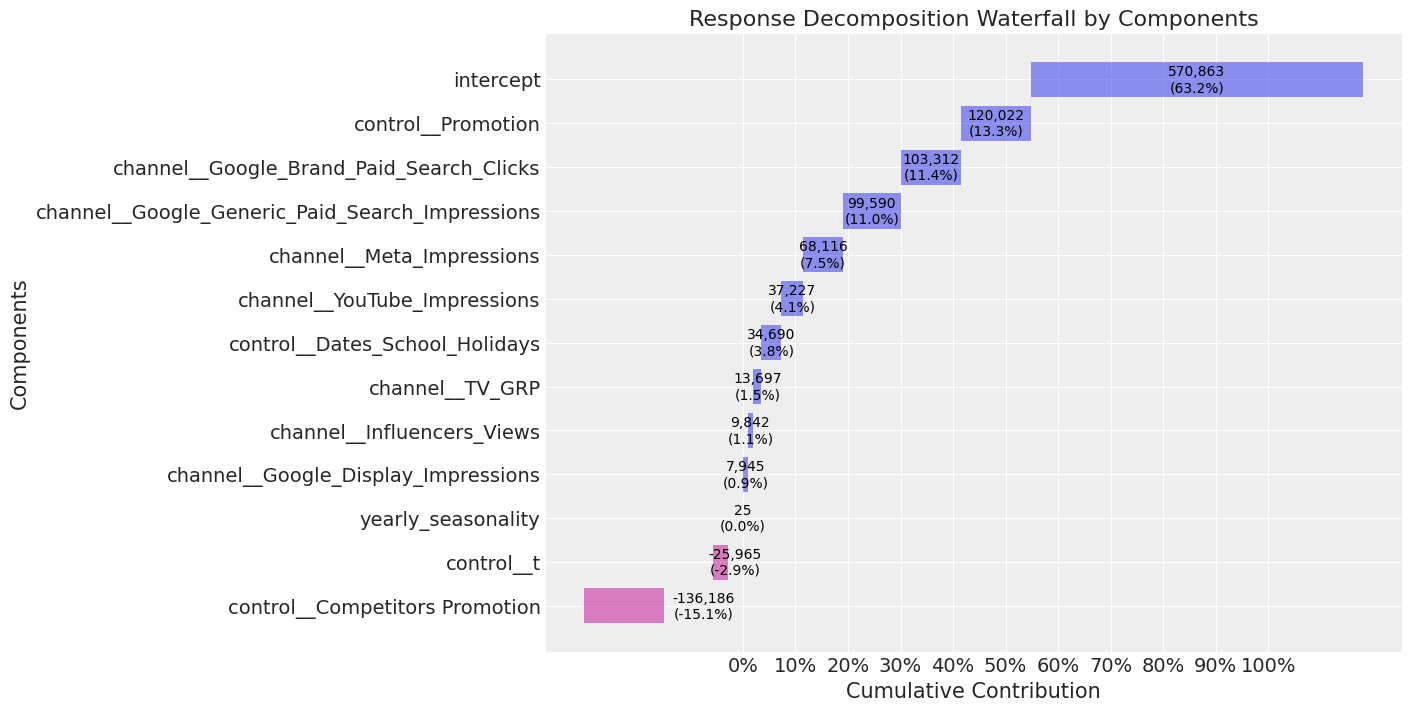

In [ ]:
#waterfall chart

mmm.plot.waterfall_components_decomposition();

In [ ]:
# Calculate mean individual contributions for each component over time

# Individual channel contributions (e.g., Google_Display_Impressions, Meta_Impressions)
mean_channel_contrib_df = mmm.fit_result["channel_contribution_original_scale"].mean(dim=["chain", "draw"]).to_pandas()

# Individual control contributions (e.g., Dates_School_Holidays, Competitors Promotion)
mean_control_contrib_df = mmm.fit_result["control_contribution_original_scale"].mean(dim=["chain", "draw"]).to_pandas()

# Yearly seasonality contribution
mean_yearly_seasonality_contrib_df = mmm.fit_result["yearly_seasonality_contribution_original_scale"].mean(dim=["chain", "draw"]).to_pandas()

# Intercept contribution (constant over time, broadcast to all dates)
mean_intercept_contrib = mmm.fit_result["intercept_contribution_original_scale"].mean(dim=["chain", "draw"]).item()
num_dates = mean_channel_contrib_df.shape[0]
dates_index = mean_channel_contrib_df.index
intercept_series = pd.Series([mean_intercept_contrib] * num_dates, index=dates_index, name='intercept_contribution')

# Combine all contributions into a single DataFrame
combined_contributions_df_individual = pd.concat(
    [
        mean_channel_contrib_df,
        mean_control_contrib_df,
        mean_yearly_seasonality_contrib_df.rename('yearly_seasonality_contribution'),
        intercept_series
    ],
    axis=1
)

# Ensure 'date' is a column for plotting
combined_contributions_df_individual = combined_contributions_df_individual.reset_index()
combined_contributions_df_individual['date'] = pd.to_datetime(combined_contributions_df_individual['date'])

display(combined_contributions_df_individual.head())

,date,Google_Brand_Paid_Search_Clicks,Google_Display_Impressions,Google_Generic_Paid_Search_Impressions,Influencers_Views,Meta_Impressions,TV_GRP,YouTube_Impressions,Competitors Promotion,Dates_School_Holidays,Promotion,t,yearly_seasonality_contribution,intercept_contribution
0,2022-01-01,380.990131,0.073477,169.521570,0.000000,288.876858,0.000000,49.527897,-643.316406,0.000000,567.451847,0.000000,92.290863,3636.068329
1,2022-01-08,548.827500,1.615927,243.240184,769.355065,336.524607,0.000000,65.385074,-643.316406,698.447660,567.451847,-2.120277,220.164461,3636.068329
2,2022-01-15,723.362974,0.578738,282.954393,655.148519,299.197168,62.376424,144.335982,-643.316406,814.855603,567.451847,-4.240554,347.509350,3636.068329
3,2022-01-22,891.588184,4.839765,331.187421,296.935936,316.493652,453.779382,199.735908,-643.316406,814.855603,567.451847,-6.360830,468.211919,3636.068329
4,2022-01-29,941.817033,1.667035,353.772198,207.538497,416.380491,583.989735,398.116188,-643.316406,814.855603,567.451847,-8.481107,576.347655,3636.068329


In [ ]:
#export as csv

combined_contributions_df_individual.to_csv('combined_contributions_individual.csv', index=False)
print("combined_contributions_individual.csv exported successfully!")

combined_contributions_individual.csv exported successfully!


/tmp/ipython-input-420/3409691838.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


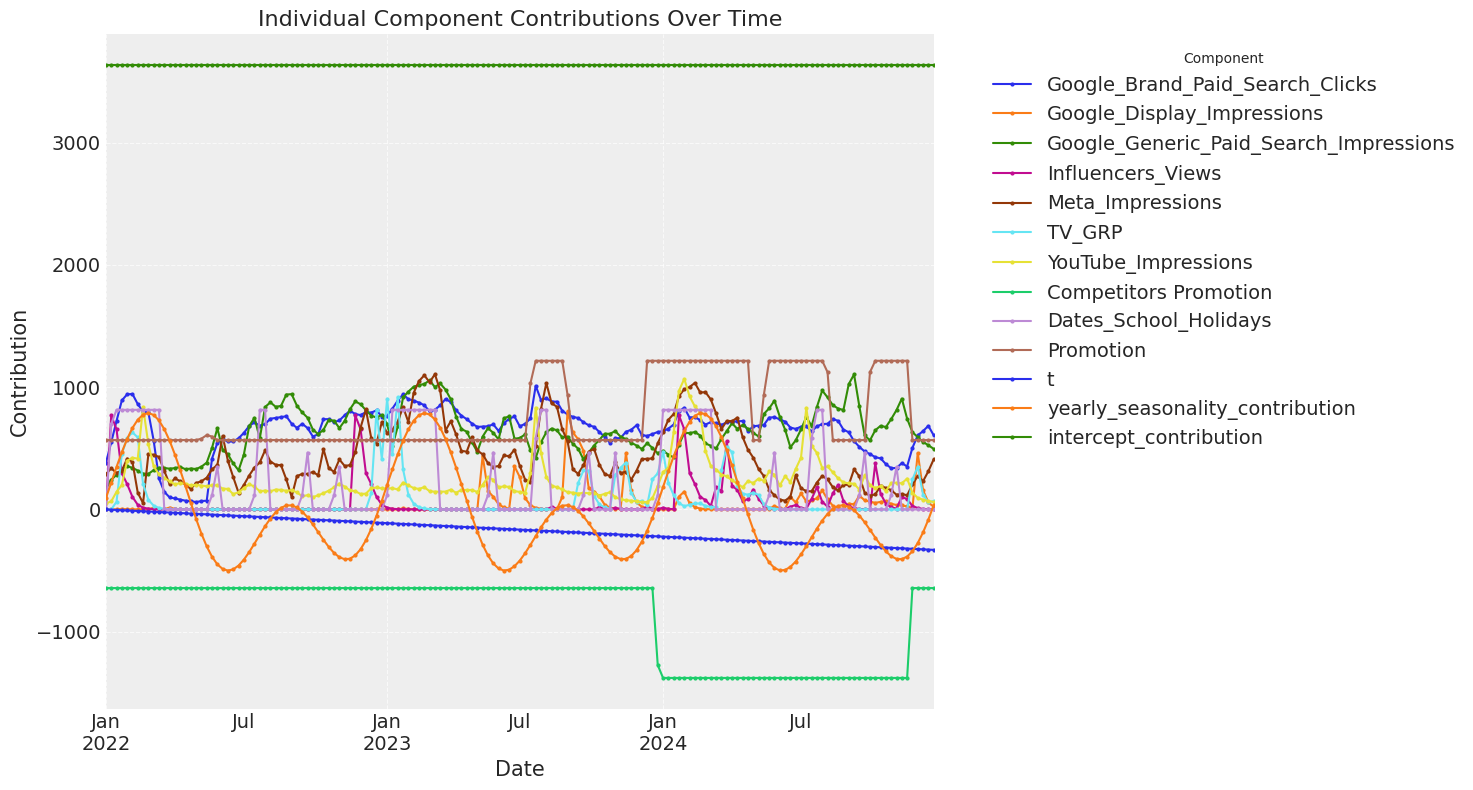

In [ ]:
# plot trended view

fig, ax = plt.subplots(figsize=(15, 8))

# Drop the 'date' column for plotting the contributions
plot_df = combined_contributions_df_individual.set_index('date')

# Plot each contribution as a separate line
plot_df.plot(ax=ax, kind='line', marker='o', markersize=2, linewidth=1.5)

ax.set_title('Individual Component Contributions Over Time');
ax.set_ylabel('Contribution');
ax.set_xlabel('Date');
ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# interactive trended view

# Define the categories of variables for filtering
channel_cols = [
    "Google_Display_Impressions",
    "Meta_Impressions",
    "Google_Generic_Paid_Search_Impressions",
    "TV_GRP",
    "Influencers_Views",
    "Google_Brand_Paid_Search_Clicks",
    "YouTube_Impressions",
]
control_cols = [
    "Dates_School_Holidays",
    "Competitors Promotion",
    "Promotion",
    "t",
]
other_cols = ["yearly_seasonality_contribution", "intercept_contribution"]

# Combine all available columns into a single list
all_available_cols = channel_cols + control_cols + other_cols

# Create a single interactive widget for all variables
variable_selector = widgets.SelectMultiple(
    options=all_available_cols,
    value=all_available_cols[:5],  # Select first few variables by default
    description='Variables',
    disabled=False,
    rows=min(len(all_available_cols), 10), # Limit rows for display, or show all if less than 10
    layout=widgets.Layout(width='auto', height='auto')
)

# Output widget to display the plot
plot_output = widgets.Output()

def plot_contributions(selected_variables):
    with plot_output:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(15, 8))

        if not selected_variables:
            print("Please select at least one variable to display.")
            return

        plot_df_filtered = combined_contributions_df_individual[['date'] + list(selected_variables)].set_index('date')

        if not plot_df_filtered.empty:
            plot_df_filtered.plot(ax=ax, kind='line', marker='o', markersize=2, linewidth=1.5)

            ax.set_title('Individual Component Contributions Over Time (Filtered)');
            ax.set_ylabel('Contribution');
            ax.set_xlabel('Date');
            ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print("No data to plot for the selected variables.")

# Link the single widget to the plotting function
interactive_plot = widgets.interactive(plot_contributions,
                                       selected_variables=variable_selector)

# Display the single widget and the plot output
display(widgets.VBox([variable_selector, plot_output]))
interactive_plot